# Predicting Opioid Mortality Rate - In Depth Analysis (Machine Learning)

In [170]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

In [24]:
merged_remove = pd.read_csv('merged_remove.csv')

y = merged_remove['Crude Opioid Mortality Rate (per 100,000)']
X = merged_remove.drop(columns = 'Crude Opioid Mortality Rate (per 100,000)')

# Road Map

1. PCA
3. Multiple Linear Regression
4. Linear Regression with Regularization
    * Ridge Regression
    * LASSO Regression
    * Elastic Net Regression
* CART
6. Random Forest Regression
7. Stochastic Gradient Boosting Regression
    * scikit-learn
    * xgboost

# Principal Component Analysis

/root/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


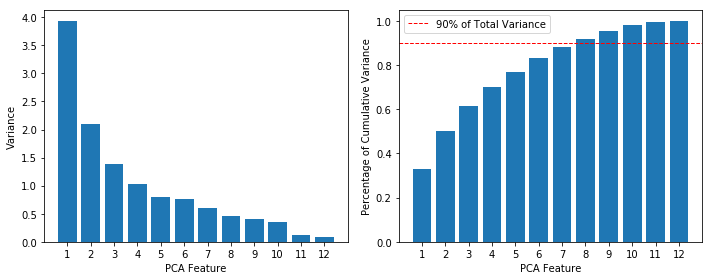

In [47]:
scaler = StandardScaler() # scale data to mean 0 and variance 1

pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(X)

# Plot the explained variances
variance_by_pc = np.array(range(pca.n_components_)) + 1

f, (ax1 ,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

ax1.bar(variance_by_pc, pca.explained_variance_)
ax1.set_xlabel('PCA Feature')
ax1.set_ylabel('Variance')
ax1.set_xticks(ticks = variance_by_pc)

ax2.bar(variance_by_pc, np.cumsum(pca.explained_variance_ratio_))
ax2.set_xlabel('PCA Feature')
ax2.set_ylabel('Percentage of Cumulative Variance')
ax2.set_xticks(ticks = variance_by_pc)
ax2.axhline(y = 0.9, linestyle = 'dashed', linewidth=1, color='r', label = '90% of Total Variance')
ax2.legend()

f.tight_layout()
f.show()

In [28]:
pca_features = pipeline.transform(X)

In [29]:
pca_features.shape

(2962, 12)

In [30]:
%matplotlib inline

/root/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


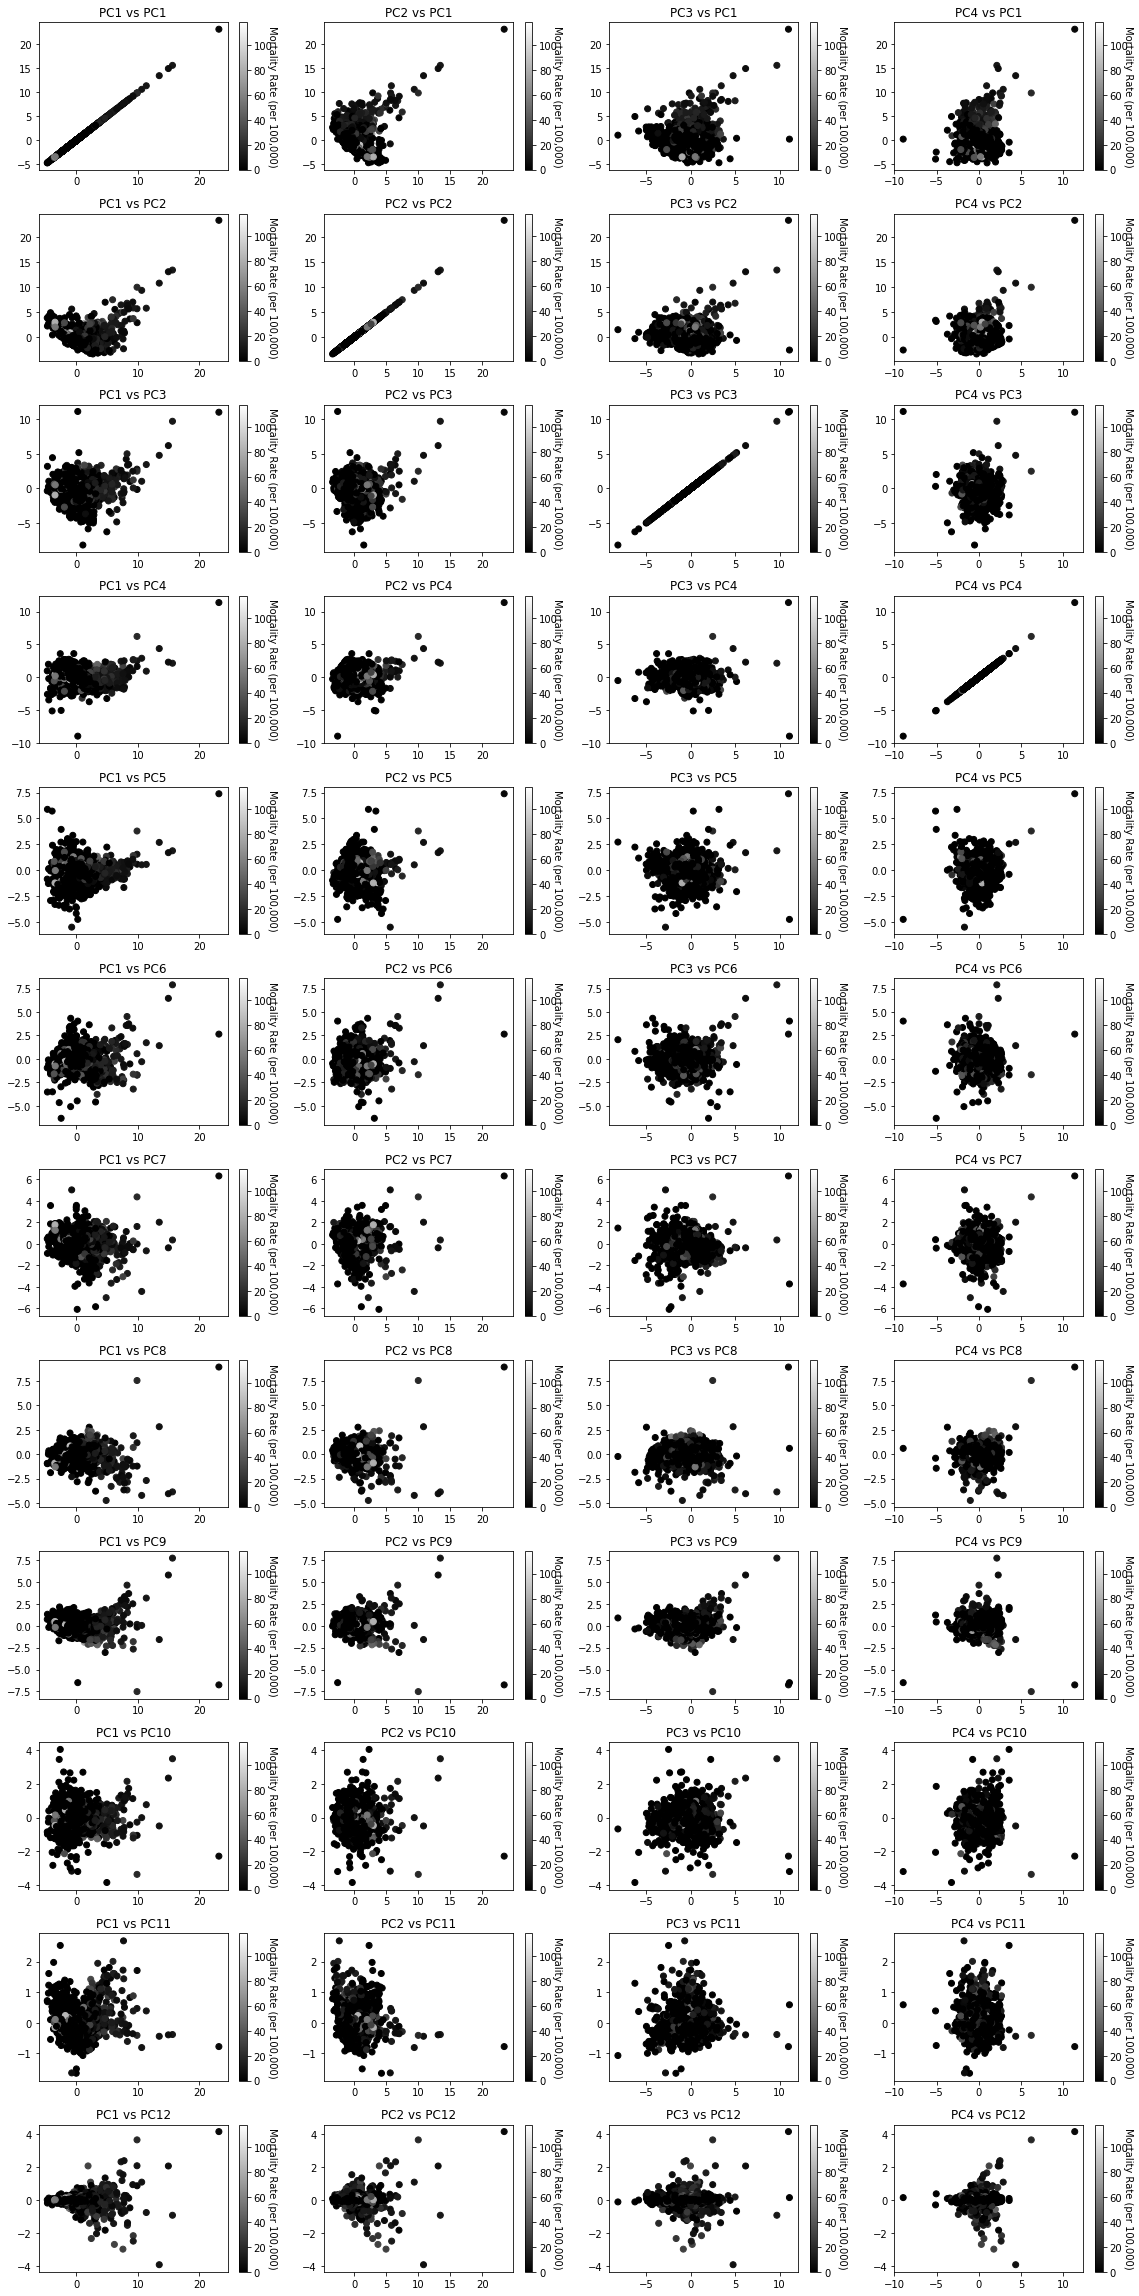

In [65]:
nrows, ncols = 12, 4

f, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (16, 32))

for i, ax in enumerate(axes):
    
    for j in range(ncols):
        
        pos = ax[j].scatter(x = pca_features[:, j], y = pca_features[:, i], c = y, cmap='gray')
        ax[j].set_title('PC{} vs PC{}'.format(j+1,i+1))
        cbar = f.colorbar(mappable = pos, ax = ax[j])
        cbar.set_label('Mortality Rate (per 100,000)', rotation = 270)

f.tight_layout()    
f.show()

In [ ]:
# set seed for reproducibility
SEED = 1

# split dataset into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)

# Multiple Linear Regression

In [175]:
# Multiple Linear Regression

# set up the pipeline steps: steps
steps = [('st_scaler', StandardScaler()),
         ('linear', LinearRegression())]

linear_pipeline = Pipeline(steps)

# fit to the training data
linear_pipeline.fit(X_train, y_train)

# predict the test set labels
y_pred = linear_pipeline.predict(X_test)

# Compute rmse_test
rmse_test = MSE(y_test, y_pred)**0.5

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test)) 

Test RMSE of best model: 10.561


# Ridge Regression

## No Hyperparameter Tuning

In [150]:
# Ridge (no hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('st_scaler', StandardScaler()),
         ('ridge', Ridge(random_state = SEED))]

ridge_pipeline = Pipeline(steps)

# fit to the training data
ridge_pipeline.fit(X_train, y_train)

# predict the test set labels
y_pred = ridge_pipeline.predict(X_test)

# Compute rmse_test
rmse_test = MSE(y_test, y_pred)**0.5

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test)) 

Test RMSE of best model: 10.561


# Ridge Regression

## Hyperparameter Tuning

In [154]:
# Ridge (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('st_scaler', StandardScaler()),
         ('ridge', Ridge(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
ridge_pipeline = Pipeline(steps)

ridge_param_grid = dict(ridge__alpha= np.logspace(-10, 0, 500),
                        ridge__fit_intercept= [True, False])

ridge_randomized_neg_mse = RandomizedSearchCV(estimator = ridge_pipeline, 
                                 param_distributions = ridge_param_grid, 
                                 scoring = 'neg_mean_squared_error', 
                                 cv = 5,
                                 n_iter = 200,
                                 n_jobs = -1,
                                 verbose = 1)

# fit 'grid_ridge' to the training data
ridge_randomized_neg_mse.fit(X_train, y_train)

# Extract the best hyperparameters from 'grid_ridge'
best_hyperparams = ridge_randomized_neg_mse.best_params_

print('Best hyerparameters:\n', best_hyperparams)

# extract best model from 'grid_ridge'
best_model = ridge_randomized_neg_mse.best_estimator_

# predict the test set labels
y_pred = best_model.predict(X_test)

# Compute rmse_test
rmse_test = MSE(y_test, y_pred)**0.5

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test)) 

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best hyerparameters:
 {'ridge__fit_intercept': True, 'ridge__alpha': 0.8707224849239904}
Test RMSE of best model: 10.561


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.0s finished


# LASSO Regression

## No Hyperparameter Tuning

In [147]:
# LASSO (no hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('st_scaler', StandardScaler()),
         ('lasso', Lasso(random_state = SEED))]

lasso_pipeline = Pipeline(steps)

# fit to the training data
lasso_pipeline.fit(X_train, y_train)

# predict the test set labels
y_pred = lasso_pipeline.predict(X_test)

# Compute rmse_test
rmse_test = MSE(y_test, y_pred)**0.5

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test)) 

Test RMSE of best model: 10.944


# LASSO Regression

## Hyperparameter Tuning

In [155]:
# LASSO (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('st_scaler', StandardScaler()),
         ('lasso', Lasso(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
lasso_pipeline = Pipeline(steps)

lasso_param_grid = dict(lasso__alpha= np.logspace(-10, 0, 500),
                        lasso__fit_intercept= [True, False])

lasso_randomized_neg_mse = RandomizedSearchCV(estimator = lasso_pipeline, 
                                 param_distributions = lasso_param_grid, 
                                 scoring = 'neg_mean_squared_error', 
                                 cv = 5,
                                 n_iter = 200,
                                 n_jobs = -1,
                                 verbose = 1)

# fit 'grid_lasso' to the training data
lasso_randomized_neg_mse.fit(X_train, y_train)

# Extract the best hyperparameters from 'grid_lasso'
best_hyperparams = lasso_randomized_neg_mse.best_params_

print('Best hyerparameters:\n', best_hyperparams)

# extract best model from 'grid_lasso'
best_model = lasso_randomized_neg_mse.best_estimator_

# predict the test set labels
y_pred = best_model.predict(X_test)

# Compute rmse_test
rmse_test = MSE(y_test, y_pred)**0.5

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test)) 

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done 764 tasks      | elapsed:    2.4s


Best hyerparameters:
 {'lasso__fit_intercept': True, 'lasso__alpha': 1.0966805983368696e-10}
Test RMSE of best model: 10.561


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.1s finished


# Elastic Net Regression

## No Hyperparameter Tuning

In [168]:
# Elastic Net (no hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('st_scaler', StandardScaler()),
         ('elastic_net', ElasticNet(random_state = SEED))]

elastic_net_pipeline = Pipeline(steps)

# fit to the training data
elastic_net_pipeline.fit(X_train, y_train)

# predict the test set labels
y_pred = elastic_net_pipeline.predict(X_test)

# Compute rmse_test
rmse_test = MSE(y_test, y_pred)**0.5

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test)) 

Test RMSE of best model: 10.901


# Elastic Net

## Hyperparameter Tuning

In [169]:
# Elastic Net (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('st_scaler', StandardScaler()),
         ('elastic_net', ElasticNet(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
elastic_net_pipeline = Pipeline(steps)

elastic_net_param_grid = dict(elastic_net__alpha= np.logspace(-10, 0, 500),
                              elastic_net__l1_ratio = np.arange(0, 1, 0.01),
                              elastic_net__fit_intercept= [True, False])

elastic_net_randomized_neg_mse = RandomizedSearchCV(estimator = elastic_net_pipeline, 
                                 param_distributions = elastic_net_param_grid, 
                                 scoring = 'neg_mean_squared_error', 
                                 cv = 5,
                                 n_iter = 200,
                                 n_jobs = -1,
                                 verbose = 1)

# fit 'grid_elastic_net' to the training data
elastic_net_randomized_neg_mse.fit(X_train, y_train)

# Extract the best hyperparameters from 'grid_elastic_net'
best_hyperparams = elastic_net_randomized_neg_mse.best_params_

print('Best hyerparameters:\n', best_hyperparams)

# extract best model from 'grid_elastic_net'
best_model = elastic_net_randomized_neg_mse.best_estimator_

# predict the test set labels
y_pred = best_model.predict(X_test)

# Compute rmse_test
rmse_test = MSE(y_test, y_pred)**0.5

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test)) 

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:    2.7s


Best hyerparameters:
 {'elastic_net__l1_ratio': 0.19, 'elastic_net__fit_intercept': True, 'elastic_net__alpha': 0.00596418494584246}
Test RMSE of best model: 10.556


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.0s finished


# Classification and Regressor Tree (CART)

## No Hyperparameter Tuning

In [139]:
# CART (no hyperparameter tuning)

# Instantiate dt
dt = DecisionTreeRegressor(random_state=SEED)

# Fit dt to the training set
dt.fit(X_train, y_train)

# Predict test set labels
y_pred = dt.predict(X_test)

# Compute MSE
mse_test = MSE(y_test, y_pred)

# Compute RMSE
rmse_test = mse_test**0.5

# Print RMSE
print('Test set RMSE of dt: {:.3f}'.format(rmse_test))

Test set RMSE of dt: 11.750


# Classification and Regressor Tree (CART)

## Hyperparameter Tuning

In [137]:
# CART (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('dt', DecisionTreeRegressor(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
dt_pipeline = Pipeline(steps)

dt_param_grid = dict(dt__max_depth= np.arange(1, 50, 10),
                     dt__min_samples_split= np.arange(2, 50, 2),
                     dt__min_samples_leaf= np.arange(1, 100, 2))

dt_randomized_neg_mse = RandomizedSearchCV(estimator = dt_pipeline, 
                                 param_distributions = dt_param_grid, 
                                 scoring = 'neg_mean_squared_error', 
                                 cv = 5,
                                 n_iter = 50,
                                 n_jobs = -1,
                                 verbose = 1)

# fit 'grid_dt' to the training data
dt_randomized_neg_mse.fit(X_train, y_train)

# Extract the best hyperparameters from 'grid_dt'
best_hyperparams = dt_randomized_neg_mse.best_params_

print('Best hyerparameters:\n', best_hyperparams)

# extract best model from 'grid_dt'
best_model = dt_randomized_neg_mse.best_estimator_

# predict the test set labels
y_pred = best_model.predict(X_test)

# Compute rmse_test
rmse_test = MSE(y_test, y_pred)**0.5

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test)) 

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyerparameters:
 {'dt__min_samples_split': 18, 'dt__min_samples_leaf': 87, 'dt__max_depth': 11}
Test RMSE of best model: 9.575


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.1s finished


# Random Forest Regressor

## No Hyperparameter Tuning

In [138]:
#  random forest (no hyperparameter tuning)

# Instantiate rf
rf = RandomForestRegressor(random_state=SEED)

# Fit rf to the training set
rf.fit(X_train, y_train)

# Predict test set labels
y_pred = rf.predict(X_test)

# Compute MSE
mse_test = MSE(y_test, y_pred)

# Compute RMSE
rmse_test = mse_test**0.5

# Print RMSE
print('Test set RMSE of rf: {:.3f}'.format(rmse_test))

Test set RMSE of rf: 9.772


# Random Forest Regressor

## Hyperparameter Tuning

In [199]:
# RandomForest (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('rf', RandomForestRegressor(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
rf_pipeline = Pipeline(steps)

rf_param_grid = dict(rf__n_estimators = np.arange(2, 500, 10),
                     rf__max_depth= np.arange(1, 50, 10),
                     rf__max_features= np.arange(0.05, 1, 0.05),
                     rf__min_samples_split= np.arange(2, 50, 2),
                     rf__min_samples_leaf= np.arange(1, 100, 2),
                     rf__bootstrap= [True, False])

rf_randomized_neg_mse = RandomizedSearchCV(estimator = rf_pipeline, 
                                 param_distributions = rf_param_grid, 
                                 scoring = 'neg_mean_squared_error', 
                                 cv = 5,
                                 n_iter = 50,
                                 n_jobs = -1,
                                 verbose = 1)

# fit 'grid_rf' to the training data
rf_randomized_neg_mse.fit(X_train, y_train)

# Extract the best hyperparameters from 'grid_rf'
best_hyperparams = rf_randomized_neg_mse.best_params_

print('Best hyerparameters:\n', best_hyperparams)

# extract best model from 'grid_rf'
best_model = rf_randomized_neg_mse.best_estimator_

# predict the test set labels
y_pred = best_model.predict(X_test)

# Compute rmse_test
rmse_test = MSE(y_test, y_pred)**0.5

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test)) 

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.1min finished


Best hyerparameters:
 {'rf__n_estimators': 262, 'rf__min_samples_split': 16, 'rf__min_samples_leaf': 5, 'rf__max_features': 0.55, 'rf__max_depth': 31, 'rf__bootstrap': True}
Test RMSE of best model: 9.062


# Feature Importance Based on Random Forest Best Model

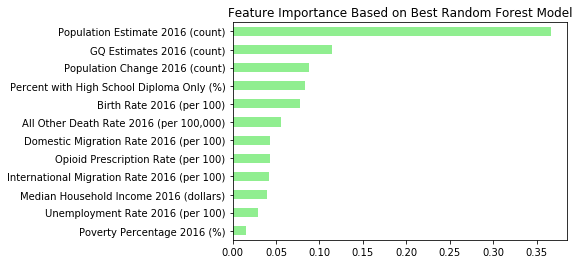

In [201]:
# create a pd.Series of features importances
importances_rf = pd.Series(best_model.steps[0][1].feature_importances_, index = X.columns)

# sort importances_rf
sorted_importances_rf = importances_rf.sort_values()

# make a horizontal bar plot
sorted_importances_rf.plot(kind = 'barh', color = 'lightgreen')
plt.title('Feature Importance Based on Best Random Forest Model')
plt.show()

# Gradient Boosting Regressor

## No Hyperparameter Tuning

In [79]:
#  gradient boosting using scikit-learn (no hyperparameter tuning)

# Instantiate gb
gb = GradientBoostingRegressor(random_state=SEED)

# Fit gb to the training set
gb.fit(X_train, y_train)

# Predict test set labels
y_pred = gb.predict(X_test)

# Compute MSE
mse_test = MSE(y_test, y_pred)

# Compute RMSE
rmse_test = mse_test**0.5

# Print RMSE
print('Test set RMSE of gb: {:.3f}'.format(rmse_test))

Test set RMSE of gb: 9.233


# Gradient Boosting Regressor

## Hyperparameter Tuning

In [134]:
# gradient boosting regressor using scikit-learn (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('gb', GradientBoostingRegressor(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
gb_pipeline = Pipeline(steps)

gb_param_grid = dict(gb__n_estimators = np.arange(2, 500, 10),
                      gb__max_depth= np.arange(1, 50, 10),
                      gb__min_samples_split= np.arange(2, 50, 2),
                      gb__min_samples_leaf= np.arange(1, 100, 2),
                      gb__learning_rate = np.arange(0.05, 1, 0.05))

gb_randomized_neg_mse = RandomizedSearchCV(estimator = gb_pipeline, 
                                            param_distributions = gb_param_grid, 
                                            scoring = 'neg_mean_squared_error', 
                                            cv = 5,
                                            n_iter = 50,
                                            n_jobs = -1,
                                            verbose = 1)

# fit 'grid_gb' to the training data
gb_randomized_neg_mse.fit(X_train, y_train)

# Extract the best hyperparameters from 'grid_gb'
best_hyperparams = gb_randomized_neg_mse.best_params_

print('Best hyerparameters:\n', best_hyperparams)

# extract best model from 'grid_gb'
best_model = gb_randomized_neg_mse.best_estimator_

# predict the test set labels
y_pred = best_model.predict(X_test)

# Compute rmse_test
rmse_test = MSE(y_test, y_pred)**0.5

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test)) 

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.0min finished


Best hyerparameters:
 {'gb__n_estimators': 32, 'gb__min_samples_split': 22, 'gb__min_samples_leaf': 99, 'gb__max_depth': 41, 'gb__learning_rate': 0.2}
Test RMSE of best model: 9.087


# Stochastic Gradient Boosting Regressor (scikit-learn)

## No Hyperparameter Tuning

In [130]:
# stochastic gradient boosting regressor using scikit-learn (no parameter tuning)

# Instantiate sgbr
sgbr = GradientBoostingRegressor(subsample=0.9,
            max_features=0.75,
            random_state=SEED)

# Fit sgbr to the training set
sgbr.fit(X_train, y_train)

# Predict test set labels
y_pred = sgbr.predict(X_test)

# Compute test set MSE
mse_test = MSE(y_test, y_pred)

# Compute test set RMSE
rmse_test = mse_test**0.5

# Print rmse_test
print('Test set RMSE of sgbr: {:.3f}'.format(rmse_test))

Test set RMSE of sgbr: 9.002


# Stochastic Gradient Boosting Regressor (scikit-learn)

## Hyperparameter Tuning

In [129]:
# stochastic gradient boosting regressor using scikit-learn (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('sgb', GradientBoostingRegressor(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
sgb_pipeline = Pipeline(steps)

sgb_param_grid = dict(sgb__n_estimators = np.arange(2, 500, 10),
                      sgb__max_depth= np.arange(1, 50, 10),
                      sgb__max_features= np.arange(0.05, 1, 0.05),
                      sgb__min_samples_split= np.arange(2, 50, 2),
                      sgb__min_samples_leaf= np.arange(1, 100, 2),
                      sgb__subsample= np.arange(0.05, 1, 0.05),
                      sgb__learning_rate = np.arange(0.05, 1, 0.05))

sgb_randomized_neg_mse = RandomizedSearchCV(estimator = sgb_pipeline, 
                                            param_distributions = sgb_param_grid, 
                                            scoring = 'neg_mean_squared_error', 
                                            cv = 5,
                                            n_iter = 50,
                                            n_jobs = -1,
                                            verbose = 1)

# fit 'grid_sgb' to the training data
sgb_randomized_neg_mse.fit(X_train, y_train)

# Extract the best hyperparameters from 'grid_sgb'
best_hyperparams = sgb_randomized_neg_mse.best_params_

print('Best hyerparameters:\n', best_hyperparams)

# extract best model from 'grid_sgb'
best_model = sgb_randomized_neg_mse.best_estimator_

# predict the test set labels
y_pred = best_model.predict(X_test)

# Compute rmse_test
rmse_test = MSE(y_test, y_pred)**0.5

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test)) 

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.0min finished


Best hyerparameters:
 {'sgb__subsample': 0.9000000000000001, 'sgb__n_estimators': 252, 'sgb__min_samples_split': 26, 'sgb__min_samples_leaf': 49, 'sgb__max_features': 0.35000000000000003, 'sgb__max_depth': 31, 'sgb__learning_rate': 0.05}
Test RMSE of best model: 9.091


# Stochastic Gradient Boosting Regressor (xgboost)

## No Hyperparameter Tuning

In [176]:
# stochastic gradient boosting regressor using xgboost (no parameter tuning)

# Instantiate xgbr
xgbr = xgb.XGBRegressor(subsample=0.9,
            colsample_bytree=0.75,
            random_state=SEED)

# Fit xgbr to the training set
xgbr.fit(X_train, y_train)

# Predict test set labels
y_pred_xgbr = xgbr.predict(X_test)

# Compute test set MSE
mse_test = MSE(y_test, y_pred_xgbr)

# Compute test set RMSE
rmse_test = mse_test**0.5

# Print rmse_test
print('Test set RMSE of xgbr: {:.3f}'.format(rmse_test))

Test set RMSE of xgbr: 8.980


# Feature Importance Based on XGBoost Best Model

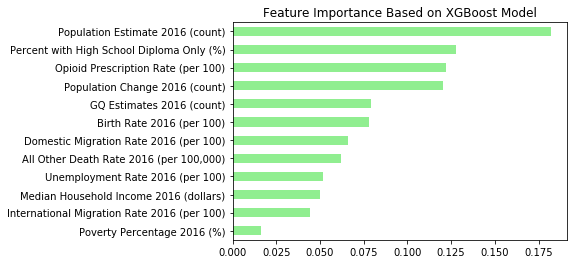

In [196]:
# create a pd.Series of features importances
importances_rf = pd.Series(xgbr.feature_importances_, index = X.columns)

# sort importances_rf
sorted_importances_rf = importances_rf.sort_values()

# make a horizontal bar plot
sorted_importances_rf.plot(kind = 'barh', color = 'lightgreen')
plt.title('Feature Importance Based on XGBoost Model')
plt.show()

# Stochastic Gradient Boosting Regressor (xgboost)

## Hyperparameter Tuning

In [131]:
# Stochastic Gradient Boosting Regressor using xgboost package (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('xgb', xgb.XGBRegressor(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
xgb_pipeline = Pipeline(steps)

xgb_param_grid = dict(xgb__n_estimators = np.arange(2, 500, 10),
                      xgb__max_depth= np.arange(1, 50, 1),
                      xgb__subsample= np.arange(0.05, 1, 0.05),
                      xgb__colsample_bytree = np.arange(0.05, 1, 0.05),
                      xgb__learning_rate = np.arange(0.05, 1, 0.05))

xgb_randomized_neg_mse = RandomizedSearchCV(estimator = xgb_pipeline, 
                                 param_distributions = xgb_param_grid, 
                                 scoring = 'neg_mean_squared_error', 
                                 cv = 5,
                                 n_iter = 50,
                                 verbose = 1,
                                 n_jobs = -1)

# fit 'grid_xgb' to the training data
xgb_randomized_neg_mse.fit(X_train, y_train)

# Extract the best hyperparameters from 'grid_xgb'
best_hyperparams = xgb_randomized_neg_mse.best_params_

print('Best hyerparameters:\n', best_hyperparams)

# extract best model from 'grid_xgb'
best_model = xgb_randomized_neg_mse.best_estimator_

# predict the test set labels
y_pred = best_model.predict(X_test)

# Compute rmse_test
rmse_test = MSE(y_test, y_pred)**0.5

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test)) 

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   50.7s finished


Best hyerparameters:
 {'xgb__subsample': 0.7000000000000001, 'xgb__n_estimators': 252, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.15000000000000002, 'xgb__colsample_bytree': 0.9000000000000001}
Test RMSE of best model: 9.274


# Predict Opioid Overdose Mortality Rate for All Counties Using Best Model

In [184]:
y_pred_best_overall_model = xgbr.predict(X)

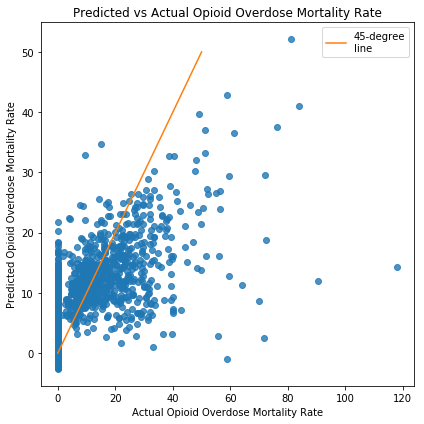

In [185]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

_ = sns.regplot(y = y_pred_best_overall_model, x = y, fit_reg = False, ax = ax)
_ = ax.set_ylabel('Predicted Opioid Overdose Mortality Rate')
_ = ax.set_xlabel('Actual Opioid Overdose Mortality Rate')
_ = ax.set_title('Predicted vs Actual Opioid Overdose Mortality Rate')
_ = ax.plot([0, 50], [0, 50]) # 45 degree line
_ = ax.legend(['45-degree\nline'], frameon = True)

fig.tight_layout()
fig.show()

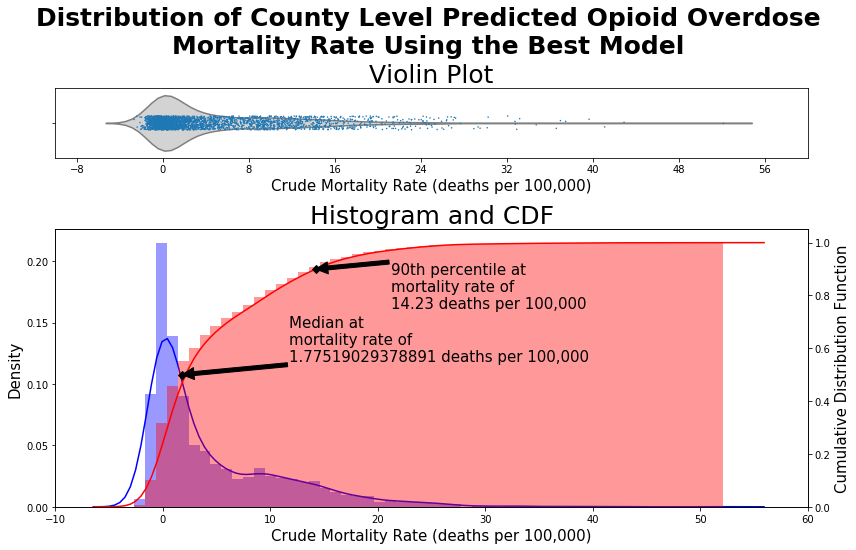

In [193]:
# Calculate number of bins to use for histogram
# Number of bins is the square root of number of data points: n_bins
n_data = len(y_pred_best_overall_model)
n_bins = np.sqrt(n_data)
# Convert number of bins to integer: n_bins
n_bins = int(n_bins)

# Cut the figure in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, gridspec_kw={"height_ratios": (.2, .8)}, figsize = (12, 8))

# Add violinplot to first subplot
sns.violinplot(y_pred_best_overall_model, inner = None, color = 'lightgray', ax = ax_box)
sns.stripplot(y_pred_best_overall_model, size = 1.5, jitter = True, ax = ax_box)

# Set x-axis name for the violinplot
ax_box.set_xlabel('Crude Mortality Rate (deaths per 100,000)', fontsize = 15)
# Set x-axis range
ax_box.set_xlim((-10, 60))
# Set number of tickmarks for x-axis
ax_box.xaxis.set_major_locator(plt.MaxNLocator(9))
# Set title for violinplot
ax_box.set_title("Violin Plot", fontsize = 25)

# Add histogram to second subplot
sns.distplot(y_pred_best_overall_model, color = 'blue', bins = n_bins, ax=ax_hist)

# Have an overlaying plot for second subplot
ax_hist2 =ax_hist.twinx()

# Overlay ecdf to histogram
sns.distplot(y_pred_best_overall_model, 
             color = 'red', 
             bins= n_bins, 
             kde_kws = dict(cumulative = True), 
             hist_kws=dict(cumulative=True), 
             ax=ax_hist2)

# Calculate median for cdf
median = np.percentile(y_pred_best_overall_model, 50)
# Plot point at median
_ = plt.plot(median, .5, marker='D', color='black',
         linestyle='none')
# Add arrow at median with text
ax_hist2.annotate('Median at\nmortality rate of\n{} deaths per 100,000'.format(median), 
                  xy=(median, .5), 
                  xytext=(median + 10, 0.55),
                  arrowprops=dict(facecolor='black'),
                  fontsize = 15)

# Calculate 90th percentile for cdf
percentile_90th = np.percentile(y_pred_best_overall_model, 90)
# Plot point at 90th percentile
_ = plt.plot(percentile_90th, .9, marker='D', color='black',
         linestyle='none')
# Add arrow at 90th percentile with text
ax_hist2.annotate('90th percentile at\nmortality rate of\n{} deaths per 100,000'.format(round(percentile_90th, 2)), 
                  xy=(percentile_90th, .9), 
                  xytext=(percentile_90th + 7, 0.75),
                  arrowprops=dict(facecolor='black'),
                  fontsize = 15)

# Set x-axis limit for histogram
ax_hist.set_xlim((-10, 60))

# Add axis labels for histogram and cdf
ax_hist.set_title("Histogram and CDF", fontsize = 25)
ax_hist.set_ylabel('Density', fontsize = 15)
ax_hist.set_xlabel('Crude Mortality Rate (deaths per 100,000)', fontsize = 15)
ax_hist2.set_ylabel('Cumulative Distribution Function', fontsize = 15)

# Add title to figure
f.suptitle('Distribution of County Level Predicted Opioid Overdose\nMortality Rate Using the Best Model', 
           fontsize = 25, fontweight = 'bold')

# Adjust plot layout
f.tight_layout(rect = [0, 0.03, 1, 0.9])
f.show()

In [209]:
merged_data = pd.read_csv('merged_data.csv')

In [212]:
merged_data.shape

(2962, 16)

In [213]:
merged_data['Predicted Mortality Rate'] = y_pred_best_overall_model

In [214]:
merged_data['Predicted Mortality Rate'].describe()

count    2962.000000
mean        4.656347
std         6.553112
min        -2.685920
25%         0.070095
50%         1.775190
75%         8.022240
max        52.152241
Name: Predicted Mortality Rate, dtype: float64

In [215]:
merged_data.head()

,fips_code,population,crude_opioid_mortality_rate,state,opioid_prescription_rate,%_povall_2016,pop_chg_2016,gq_estimates_2016,rate_birth_2016,rate_international_mig_2016,rate_domestic_mig_2016,%_high_school_diploma_only_2012-2016,unemployment_rate_2016,median_household_income_2016,county,mortality_rate_excluding_opioid,Predicted Mortality Rate
0,1001,55416.0,0.0,AL,129.6,14.0,440.0,455.0,12.096335,0.272440,4.831269,34.331,5.1,54487.0,Autauga,938.4,6.112959
1,1003,208563.0,8.6,AL,123.8,12.0,4646.0,2275.0,11.267825,0.823643,20.493601,28.692,5.4,56460.0,Baldwin,937.9,12.894729
2,1005,25965.0,0.0,AL,92.7,30.0,-490.0,2977.0,10.453899,-0.192167,-18.755525,34.927,8.4,32884.0,Barbour,985.9,1.570366
3,1007,22643.0,0.0,AL,97.2,20.0,72.0,2201.0,12.833562,0.885073,-1.416117,41.816,6.5,43079.0,Bibb,1055.5,1.224515
4,1009,57704.0,0.0,AL,56.9,14.0,-28.0,489.0,11.723635,1.076838,-1.736835,32.942,5.4,47213.0,Blount,1207.9,9.347027


In [221]:
merged_data.loc[:, ['county', 'state', 'crude_opioid_mortality_rate', 'Predicted Mortality Rate']].\
                            sort_values(by = 'Predicted Mortality Rate', ascending=False).head()

,county,state,crude_opioid_mortality_rate,Predicted Mortality Rate
2843,Mingo,WV,81.1,52.152241
1537,St. Louis City,MO,58.8,42.907452
2863,Wayne,WV,83.9,41.102730
2010,Trumbull,OH,49.1,39.654350
1162,Baltimore City,MD,76.1,37.474812


In [222]:
merged_data.loc[:, ['county', 'state', 'crude_opioid_mortality_rate', 'Predicted Mortality Rate']].\
                            sort_values(by = 'crude_opioid_mortality_rate', ascending=False).head()

,county,state,crude_opioid_mortality_rate,Predicted Mortality Rate
989,Harrison,KY,118.0,14.313108
2819,Cabell,WV,90.6,12.002394
2863,Wayne,WV,83.9,41.102730
2843,Mingo,WV,81.1,52.152241
1162,Baltimore City,MD,76.1,37.474812


In [223]:
merged_data.loc[:, ['county', 'state', 'crude_opioid_mortality_rate', 'Predicted Mortality Rate']].\
                            sort_values(by = 'Predicted Mortality Rate').head()

,county,state,crude_opioid_mortality_rate,Predicted Mortality Rate
1923,Rolette,ND,0.0,-2.685920
247,Gunnison,CO,0.0,-2.432783
548,Teton,ID,0.0,-2.398336
1651,Wayne,NE,0.0,-2.132180
2626,Morgan,UT,0.0,-2.121113


In [224]:
merged_data.loc[:, ['county', 'state', 'crude_opioid_mortality_rate', 'Predicted Mortality Rate']].\
                            sort_values(by = 'crude_opioid_mortality_rate').head()

,county,state,crude_opioid_mortality_rate,Predicted Mortality Rate
0,Autauga,AL,0.0,6.112959
1796,Bertie,NC,0.0,0.046612
1797,Bladen,NC,0.0,1.357677
1804,Caswell,NC,0.0,-0.391184
1806,Chatham,NC,0.0,2.104542
